## Gauss-Legendre version

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.nn.functional import softplus

## set GPU or CPU (uncomment second line to use CPU)
device = torch.device('cuda:0'); dtype = torch.float16
#device = 'cpu'; dtype = torch.float32

import time
tic = time.time()

### load the data and process it
tic_load = time.time()
away_data = pd.read_csv('https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv', skiprows=2)
home_data = pd.read_csv('https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv', skiprows=2)
toc_load = time.time()

tic_process = time.time()
jitter = 1e-12 ## prevents division by zero when player is stationary
home_pos = np.array([np.asarray(home_data.iloc[:,range(3 + j*2,3 + j*2 +2)]) for j in range(14)]) * np.array([105,68])
## set nans to large negative value -- this makes pitch control for players who aren't involved negligibly small everywhere on the pitch
np.nan_to_num(home_pos,copy=False,nan=-1000)
away_pos = np.array([np.asarray(away_data.iloc[:,range(3 + j*2,3 + j*2 +2)]) for j in range(14)]) * np.array([105,68])
np.nan_to_num(away_pos,copy=False,nan=-1000)
ball_pos = (np.asarray(home_data.iloc[:,range(31,33)]) * np.array([105,68]))[:,None,None,:]
tt = np.asarray(home_data['Time [s]'])
dt = tt[1:] - tt[:-1]
home_v = (home_pos[:,1:,:] - home_pos[:,:-1,:])/dt[:,None] + jitter
np.nan_to_num(home_v,copy=False,nan=-1000)
away_v = (away_pos[:,1:,:] - away_pos[:,:-1,:])/dt[:,None] + jitter
np.nan_to_num(away_v,copy=False,nan=-1000)
home_pos = home_pos[:,1:,None,None,:]
away_pos = away_pos[:,1:,None,None,:]
home_v = home_v[:,:,None,None,:]
away_v = away_v[:,:,None,None,:]
ball_pos = ball_pos[None,1:]
toc_process = time.time()

tic_setup = time.time()

## set up evaluation grid and set some pitch control parameters (these are taken from the FoT code)
reaction_time = 0.7
max_player_speed = 5.
average_ball_speed = 15.
sigma = np.pi / np.sqrt(3.) / 0.45
lamb = 4.3
n_grid_points_x = 50
n_grid_points_y = 30
XX,YY = torch.meshgrid(torch.linspace(0,105,n_grid_points_x,device=device,dtype=dtype),torch.linspace(0,68,n_grid_points_y,device=device,dtype=dtype))
ti,wi = np.polynomial.legendre.leggauss(50) ## used for numerical integration later on
ti = torch.tensor(ti,device = device,dtype=dtype)
wi = torch.tensor(wi,device=device,dtype=dtype)
target_position = torch.stack([XX,YY],2)[None,None,:,:,:]
n_frames = home_pos.shape[1]
first_frame = 0
batch_size = 500
tti = torch.empty([28,batch_size,n_grid_points_x,n_grid_points_y],device = device,dtype=dtype)
tmp2 = torch.empty([28,batch_size,n_grid_points_x,n_grid_points_y,1],device = device,dtype=dtype)
pc = torch.empty([n_frames,n_grid_points_x,n_grid_points_y],device = device,dtype=dtype)

toc_setup = time.time()

## compute pitch control -- I found that the batch size needed to be reduced to 250 when using the CPU
tic_loop = time.time()

for f in range(int(n_frames/batch_size)):
  bp = torch.tensor(ball_pos[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames)))],device = device,dtype=dtype)
  hp = torch.tensor(home_pos[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames)))],device = device,dtype=dtype)
  hv = torch.tensor(home_v[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames)))],device = device,dtype=dtype)
  ap = torch.tensor(away_pos[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames)))],device = device,dtype=dtype)
  av = torch.tensor(away_v[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames)))],device = device,dtype=dtype)
  ball_travel_time = torch.norm(target_position - bp, dim=4).div_(average_ball_speed)
  r_reaction_home = hp + hv.mul_(reaction_time)
  r_reaction_away = ap + av.mul_(reaction_time)
  r_reaction_home = r_reaction_home - target_position
  r_reaction_away = r_reaction_away - target_position
  tti[:14,:ball_travel_time.shape[1]] = torch.norm(r_reaction_home,dim=4).add_(reaction_time).div_(max_player_speed)
  tti[14:,:ball_travel_time.shape[1]] = torch.norm(r_reaction_away,dim=4).add_(reaction_time).div_(max_player_speed)

  tmp2[...,0] = sigma * (ball_travel_time - tti)
  tmp1 = sigma * 0.5 * (ti + 1) * 10 + tmp2
  hh = torch.sigmoid(tmp1[:14]).mul_(4.3)
  h = hh.sum(0)
  S = torch.exp(-lamb*torch.sum(softplus(tmp1) - softplus(tmp2),dim=0).div_(sigma))

  pc[(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames)))] = torch.matmul(S*h,wi).mul_(5.)

toc_loop = time.time()

toc = time.time()
print('Loading data and computing pitch control for ' + str(n_frames) + ' frames took ' + str(toc-tic) + ' seconds')
print('Loading data from Metrica Github took ' + str(toc_load-tic_load) + ' seconds')
print('Preprocessing data took ' + str(toc_process-tic_process) + ' seconds')
print('Preallocation and setting up evaluation grid took ' + str(toc_setup-tic_setup) + ' seconds')
print('Main pitch control computation took ' + str(toc_loop-tic_loop) + ' seconds')


Loading data and computing pitch control for 145005 frames took 32.38331890106201 seconds
Loading data from Metrica Github took 2.666024923324585 seconds
Preprocessing data took 0.2162795066833496 seconds
Preallocation and setting up evaluation grid took 0.002733469009399414 seconds
Main pitch control computation took 29.49819850921631 seconds


## Original finite difference scheme for comparison. 

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.nn.functional import softplus

## set GPU or CPU (uncomment second line to use CPU)
device = torch.device('cuda:0'); dtype = torch.float16
#device = 'cpu'; dtype = torch.float32

import time
tic = time.time()

### load the data and process it
tic_load = time.time()
away_data = pd.read_csv('https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv', skiprows=2)
home_data = pd.read_csv('https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv', skiprows=2)
toc_load = time.time()

tic_process = time.time()
jitter = 1e-12 ## prevents division by zero when player is stationary
home_pos = np.array([np.asarray(home_data.iloc[:,range(3 + j*2,3 + j*2 +2)]) for j in range(14)]) * np.array([105,68])
## set nans to large negative value -- this makes pitch control for players who aren't involved negligibly small everywhere on the pitch
np.nan_to_num(home_pos,copy=False,nan=-1000)
away_pos = np.array([np.asarray(away_data.iloc[:,range(3 + j*2,3 + j*2 +2)]) for j in range(14)]) * np.array([105,68])
np.nan_to_num(away_pos,copy=False,nan=-1000)
ball_pos = (np.asarray(home_data.iloc[:,range(31,33)]) * np.array([105,68]))[:,None,None,:]
tt = np.asarray(home_data['Time [s]'])
dt = tt[1:] - tt[:-1]
home_v = (home_pos[:,1:,:] - home_pos[:,:-1,:])/dt[:,None] + jitter
np.nan_to_num(home_v,copy=False,nan=-1000)
away_v = (away_pos[:,1:,:] - away_pos[:,:-1,:])/dt[:,None] + jitter
np.nan_to_num(away_v,copy=False,nan=-1000)
home_pos = home_pos[:,1:,None,None,:]
away_pos = away_pos[:,1:,None,None,:]
home_v = home_v[:,:,None,None,:]
away_v = away_v[:,:,None,None,:]
ball_pos = ball_pos[None,1:]
toc_process = time.time()

tic_setup = time.time()

## set up evaluation grid and set some pitch control parameters (these are taken from the FoT code)
reaction_time = 0.7
max_player_speed = 5.
average_ball_speed = 15.
sigma = np.pi / np.sqrt(3.) / 0.45
lamb = 4.3
n_grid_points_x = 50
n_grid_points_y = 30
XX,YY = torch.meshgrid(torch.linspace(0,105,n_grid_points_x,device=device,dtype=dtype),torch.linspace(0,68,n_grid_points_y,device=device,dtype=dtype))
ti,wi = np.polynomial.legendre.leggauss(50) ## used for numerical integration later on
ti = torch.tensor(ti,device = device,dtype=dtype)
wi = torch.tensor(wi,device=device,dtype=dtype)
target_position = torch.stack([XX,YY],2)[None,None,:,:,:]
n_frames = home_pos.shape[1]
first_frame = 0
batch_size = 500
tti = torch.empty([28,batch_size,n_grid_points_x,n_grid_points_y],device = device,dtype=dtype)
pc = torch.empty([n_frames,n_grid_points_x,n_grid_points_y],device = device,dtype=dtype)

toc_setup = time.time()

## compute pitch control -- I found that the batch size needed to be reduced to 250 when using the CPU
tic_loop = time.time()

for f in range(int(n_frames/batch_size)):
  bp = torch.tensor(ball_pos[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames)))],device = device,dtype=dtype)
  hp = torch.tensor(home_pos[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames)))],device = device,dtype=dtype)
  hv = torch.tensor(home_v[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames)))],device = device,dtype=dtype)
  ap = torch.tensor(away_pos[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames)))],device = device,dtype=dtype)
  av = torch.tensor(away_v[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames)))],device = device,dtype=dtype)
  ball_travel_time = torch.norm(target_position - bp, dim=4).div_(average_ball_speed)
  r_reaction_home = hp + hv.mul_(reaction_time)
  r_reaction_away = ap + av.mul_(reaction_time)
  r_reaction_home = r_reaction_home - target_position
  r_reaction_away = r_reaction_away - target_position
  tti[:14,:ball_travel_time.shape[1]] = torch.norm(r_reaction_home,dim=4).add_(reaction_time).div_(max_player_speed)
  tti[14:,:ball_travel_time.shape[1]] = torch.norm(r_reaction_away,dim=4).add_(reaction_time).div_(max_player_speed)

  y = torch.zeros([28,bp.shape[1],n_grid_points_x,n_grid_points_y],device = device,dtype=dtype)

  for tt in range(500):
    sumy = torch.sum(y, dim=0)
    if torch.min(sumy) > 0.99:
      break
    y += 0.02 * lamb * (1. - sumy) * 1. / (1. + torch.exp(-sigma * (0.02*tt + ball_travel_time - tti)))
  
  pc[(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames)))] = y[:14].sum(0)

toc_loop = time.time()

toc = time.time()
print('Loading data and computing pitch control for ' + str(n_frames) + ' frames took ' + str(toc-tic) + ' seconds')
print('Loading data from Metrica Github took ' + str(toc_load-tic_load) + ' seconds')
print('Preprocessing data took ' + str(toc_process-tic_process) + ' seconds')
print('Preallocation and setting up evaluation grid took ' + str(toc_setup-tic_setup) + ' seconds')
print('Main pitch control computation took ' + str(toc_loop-tic_loop) + ' seconds')


Loading data and computing pitch control for 145005 frames took 287.7726562023163 seconds
Loading data from Metrica Github took 2.1994571685791016 seconds
Preprocessing data took 0.2140657901763916 seconds
Preallocation and setting up evaluation grid took 0.0029544830322265625 seconds
Main pitch control computation took 285.3561041355133 seconds


## Plot a video of the results

In [ ]:
!pip install matplotsoccer

  Created wheel for matplotsoccer: filename=matplotsoccer-0.0.8-cp36-none-any.whl size=5984 sha256=33ef77d532ed1512c2a15113317c10b51ca2098d1b06fc25ad735b033ed86acc
  Stored in directory: /root/.cache/pip/wheels/69/af/8d/ee61635d6f863657abe8cd0c22622c408a4b980d5af1974f1f
Successfully built matplotsoccer


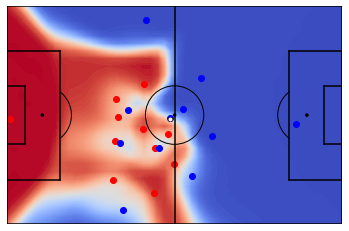

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotsoccer import field
from IPython.core.display import HTML

## use these parameters to set which frames you want to see
first_frame_to_plot = 0
n_frames_to_plot = 100


xx = np.linspace(0,105,n_grid_points_x)
yy = np.linspace(0,68,n_grid_points_y)

locs_ball_reduced = ball_pos[0,first_frame:(first_frame + n_frames),0,0,:]
locs_home_reduced = home_pos[:,first_frame:(first_frame + n_frames),0,0,:]
locs_away_reduced = away_pos[:,first_frame:(first_frame + n_frames),0,0,:]

fig, ax=plt.subplots()
field(ax=ax,show = False)
ax.set_xlim(0,105)
ax.set_ylim(0,68)
ball_points = ax.scatter(locs_ball_reduced[first_frame_to_plot,0],locs_ball_reduced[first_frame_to_plot,1],color = 'black',zorder = 15, s = 16)
ball_points2 = ax.scatter(locs_ball_reduced[first_frame_to_plot,0],locs_ball_reduced[first_frame_to_plot,1],color = 'white',zorder = 15, s = 9)
home_points = ax.scatter(locs_home_reduced[:,first_frame_to_plot,0],locs_home_reduced[:,first_frame_to_plot,1],color = 'red',zorder = 10)
away_points = ax.scatter(locs_away_reduced[:,first_frame_to_plot,0],locs_away_reduced[:,first_frame_to_plot,1],color = 'blue',zorder = 10)
p = [ax.contourf(xx,
                 yy,
                 pc[first_frame_to_plot].t().cpu(),
                 extent = (0,105,0,68),
                 levels = np.linspace(0,1,100),
                 cmap = 'coolwarm',
                 extend='both')]

def update(i):
    fr = i + first_frame_to_plot
    for tp in p[0].collections:
        tp.remove()
    p[0] = ax.contourf(xx,
                    yy,
                    pc[fr].t().cpu(),
                    extent = (0,105,0,68),
                    levels = np.linspace(0,1,100),
                    cmap = 'coolwarm',
                    extend='both')
    ball_points.set_offsets(np.c_[[locs_ball_reduced[i,0]],[locs_ball_reduced[i,1]]])
    ball_points2.set_offsets(np.c_[[locs_ball_reduced[i,0]],[locs_ball_reduced[i,1]]])
    home_points.set_offsets(np.c_[locs_home_reduced[:,i,0],locs_home_reduced[:,i,1]])
    away_points.set_offsets(np.c_[locs_away_reduced[:,i,0],locs_away_reduced[:,i,1]])
    return p[0].collections + [ball_points,home_points,away_points]

ani = matplotlib.animation.FuncAnimation(fig, update, frames=n_frames_to_plot, 
                                         interval=40, blit=True, repeat=True)
HTML(ani.to_html5_video())